In [28]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('iteration4').getOrCreate()
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)
# Evaluate the model using the binary classifer.
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
df = spark.read.csv('./quality.csv', inferSchema=True, header=True)
df.printSchema()

root
 |-- MemberID: integer (nullable = true)
 |-- InpatientDays: integer (nullable = true)
 |-- ERVisits: integer (nullable = true)
 |-- OfficeVisits: integer (nullable = true)
 |-- Narcotics: integer (nullable = true)
 |-- DaysSinceLastERVisit: double (nullable = true)
 |-- Pain: integer (nullable = true)
 |-- TotalVisits: integer (nullable = true)
 |-- ProviderCount: integer (nullable = true)
 |-- MedicalClaims: integer (nullable = true)
 |-- ClaimLines: integer (nullable = true)
 |-- StartedOnCombination: boolean (nullable = true)
 |-- AcuteDrugGapSmall: integer (nullable = true)
 |-- PoorCare: integer (nullable = true)



In [4]:

df.na.drop().show()
df=df.na.drop()

+--------+-------------+--------+------------+---------+--------------------+----+-----------+-------------+-------------+----------+--------------------+-----------------+--------+
|MemberID|InpatientDays|ERVisits|OfficeVisits|Narcotics|DaysSinceLastERVisit|Pain|TotalVisits|ProviderCount|MedicalClaims|ClaimLines|StartedOnCombination|AcuteDrugGapSmall|PoorCare|
+--------+-------------+--------+------------+---------+--------------------+----+-----------+-------------+-------------+----------+--------------------+-----------------+--------+
|       1|            0|       0|          18|        1|               731.0|  10|         18|           21|           93|       222|               false|                0|       0|
|       2|            1|       1|           6|        1|               411.0|   0|          8|           27|           19|       115|               false|                1|       0|
|       3|            0|       0|           5|        3|               731.0|  10|        

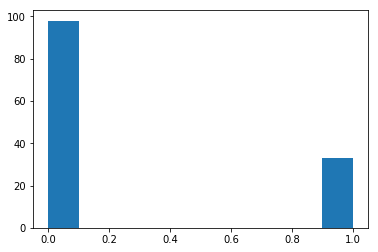

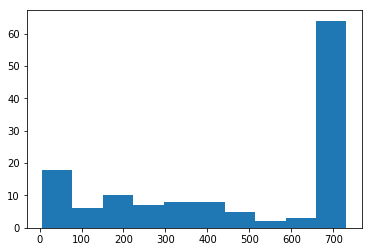

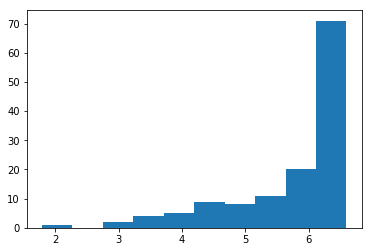

In [5]:

poorcare = np.array(df.select('PoorCare').collect())
plt.hist(poorcare)
plt.show()


DaysSinceLastERVisit = np.array(df.select('DaysSinceLastERVisit').collect())
plt.hist(DaysSinceLastERVisit)
plt.show()

DaysSinceLastERVisit_log=np.log(DaysSinceLastERVisit)

plt.hist(DaysSinceLastERVisit_log)
plt.show()





In [6]:
quality_data=pandas.read_csv('./quality.csv')
print(quality_data.columns)
print(quality_data.shape)

Index(['MemberID', 'InpatientDays', 'ERVisits', 'OfficeVisits', 'Narcotics',
       'DaysSinceLastERVisit', 'Pain', 'TotalVisits', 'ProviderCount',
       'MedicalClaims', 'ClaimLines', 'StartedOnCombination',
       'AcuteDrugGapSmall', 'PoorCare'],
      dtype='object')
(131, 14)


In [7]:
print(quality_data.corr()['PoorCare'])

MemberID                0.060916
InpatientDays           0.080726
ERVisits                0.135401
OfficeVisits            0.329512
Narcotics               0.447236
DaysSinceLastERVisit   -0.107983
Pain                    0.092168
TotalVisits             0.300540
ProviderCount           0.220166
MedicalClaims           0.167399
ClaimLines              0.129175
StartedOnCombination    0.293437
AcuteDrugGapSmall       0.341435
PoorCare                1.000000
Name: PoorCare, dtype: float64


In [8]:
# Combine all features into one vector named features.
                               
assembler = VectorAssembler(
  inputCols=['OfficeVisits',
             'Narcotics',
             'TotalVisits',
             'StartedOnCombination',
             'AcuteDrugGapSmall',
             ],
              outputCol="features")

In [19]:
# Let's transform the data. 
output = assembler.transform(df)

final_data = output.select("features",'PoorCare')

train_data,test_data = final_data.randomSplit([0.7,0.3])

# Use defaults to make the comparison "fair". This simplifies the comparison process.

dtc = DecisionTreeClassifier(labelCol='PoorCare',featuresCol='features')
rfc = RandomForestClassifier(labelCol='PoorCare',featuresCol='features')


# Train the models (it's three models, so it might take some time).
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)



In [20]:
dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)


In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Note that the label column isn't named label, it's named PrivateIndex in this case.
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'PoorCare')

In [22]:
# This is the area under the curve. This indicates that the data is highly seperable.
print("The accuracy of DTC")
print(my_binary_eval.evaluate(dtc_predictions))

# RFC improves accuracy but also model complexity. RFC outperforms DTC in nearly every situation.
print("The accuracy of RFC")
print(my_binary_eval.evaluate(rfc_predictions))

# We can't repeat these exact steps for GBT. If you print the schema of all three, you may be able to notice why.
# Instead, let's redefine the object:
my_binary_gbt_eval = BinaryClassificationEvaluator(labelCol='PoorCare', rawPredictionCol='prediction')


The accuracy of DTC
0.5716666666666668
The accuracy of RFC
0.6633333333333332


In [23]:


# Select (prediction, true label) and compute test error. 
acc_evaluator = MulticlassClassificationEvaluator(labelCol="PoorCare", predictionCol="prediction", metricName="accuracy")

dtc_acc = acc_evaluator.evaluate(dtc_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_predictions)


In [24]:
# Let's do something a bit more complex in terms of printing, just so it's formatted nicer. 
print("Here are the results!")
print('-'*40)
print('A single decision tree has an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*40)
print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))


Here are the results!
----------------------------------------
A single decision tree has an accuracy of: 70.00%
----------------------------------------
A random forest ensemble has an accuracy of: 77.50%


In [25]:
print(dtc_model.toDebugString)
print(rfc_model.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_414c952864ee5d5c5b41) of depth 5 with 27 nodes
  If (feature 1 <= 19.0)
   If (feature 0 <= 19.0)
    If (feature 1 <= 1.0)
     If (feature 0 <= 13.0)
      Predict: 0.0
     Else (feature 0 > 13.0)
      If (feature 2 <= 16.0)
       Predict: 0.0
      Else (feature 2 > 16.0)
       Predict: 0.0
    Else (feature 1 > 1.0)
     If (feature 1 <= 2.0)
      If (feature 2 <= 6.0)
       Predict: 1.0
      Else (feature 2 > 6.0)
       Predict: 0.0
     Else (feature 1 > 2.0)
      If (feature 0 <= 4.0)
       Predict: 1.0
      Else (feature 0 > 4.0)
       Predict: 0.0
   Else (feature 0 > 19.0)
    If (feature 0 <= 45.0)
     If (feature 2 <= 23.0)
      If (feature 4 <= 0.0)
       Predict: 0.0
      Else (feature 4 > 0.0)
       Predict: 1.0
     Else (feature 2 > 23.0)
      If (feature 0 <= 25.0)
       Predict: 0.0
      Else (feature 0 > 25.0)
       Predict: 0.0
    Else (feature 0 > 45.0)
     Predict: 1.0
  Else (feat

In [27]:

# Now we can assemble all of this as one vector in the features column. 
assembler = VectorAssembler(inputCols=['OfficeVisits',
             'Narcotics',
             'TotalVisits',
             'StartedOnCombination',
             'AcuteDrugGapSmall',
             ],outputCol="features")


log_reg_titanic = LogisticRegression(featuresCol='features',labelCol='PoorCare')

pipeline = Pipeline(stages=[assembler,log_reg_titanic])

train_log_data, test_log_data = df.randomSplit([0.7,.3])

fit_model = pipeline.fit(train_log_data)

# Transform test data. 
results = fit_model.transform(test_log_data)


my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='PoorCare')
# If we select the actual and predicted results, we can see that some predictions were correct while others were wrong.
results.select('PoorCare','prediction').show()

# We can then evaluate using AUC (area under the curve). AUC is linked to ROC.
AUC = my_eval.evaluate(results)

print('The accuracy of Logistic regression: {0:2.2f}%'.format(AUC*100))


+--------+----------+
|PoorCare|prediction|
+--------+----------+
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       1|       1.0|
|       1|       1.0|
|       0|       0.0|
|       1|       0.0|
|       0|       0.0|
|       0|       0.0|
|       1|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       1|       1.0|
|       0|       0.0|
|       1|       0.0|
|       0|       0.0|
|       0|       1.0|
|       0|       0.0|
+--------+----------+
only showing top 20 rows

The accuracy of Logistic regression: 71.72%


In [30]:
assembler = VectorAssembler(
  inputCols=['OfficeVisits',
             'Narcotics',
             'TotalVisits',
             'StartedOnCombination',
             'AcuteDrugGapSmall',
             'MedicalClaims',
             'ProviderCount',
             'ERVisits',
             ],
              outputCol="features")

# Let's transform the data. 
output = assembler.transform(df)

final_data = output.select("features",'PoorCare')

train_data,test_data = final_data.randomSplit([0.7,0.3])

# Use defaults to make the comparison "fair". This simplifies the comparison process.

dtc = DecisionTreeClassifier(labelCol='PoorCare',featuresCol='features')
rfc = RandomForestClassifier(labelCol='PoorCare',featuresCol='features')


# Train the models (it's three models, so it might take some time).
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)

dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)

my_binary_eval = BinaryClassificationEvaluator(labelCol = 'PoorCare')

# This is the area under the curve. This indicates that the data is highly seperable.
print("The accuracy of DTC")
print(my_binary_eval.evaluate(dtc_predictions))

# RFC improves accuracy but also model complexity. RFC outperforms DTC in nearly every situation.
print("The accuracy of RFC")
print(my_binary_eval.evaluate(rfc_predictions))


# Select (prediction, true label) and compute test error. 
acc_evaluator = MulticlassClassificationEvaluator(labelCol="PoorCare", predictionCol="prediction", metricName="accuracy")

dtc_acc = acc_evaluator.evaluate(dtc_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_predictions)


# Let's do something a bit more complex in terms of printing, just so it's formatted nicer. 
print("Here are the results!")
print('-'*40)
print('A single decision tree has an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*40)
print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))



The accuracy of DTC
0.4926108374384236
The accuracy of RFC
0.812807881773399
Here are the results!
----------------------------------------
A single decision tree has an accuracy of: 83.33%
----------------------------------------
A random forest ensemble has an accuracy of: 83.33%
